In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from models import MLP, CNN_MNIST
from utils import test

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [2]:
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=ToTensor()
)

/d/alecoz/miniconda3/envs/alc/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635068699003/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


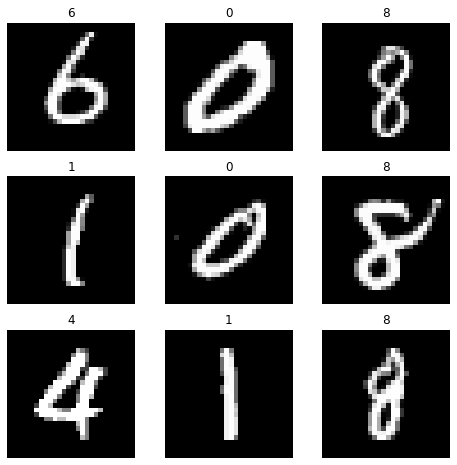

In [3]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [4]:
BATCH_SIZE = 64
HIDDEN_DIM = 64
NB_EPOCHS = 10
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [5]:
def train(dataloader, model, loss_function, optimizer):

    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print('[{}/{}] loss: {}'.format(batch*len(X), size, loss))


In [6]:
# model = MLP().to(device)
model = CNN_MNIST().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
test(test_dataloader, model, loss_function, device)
for e in range(1, NB_EPOCHS+1):
    print(f'Epoch {e}/{NB_EPOCHS}\n-------------------')
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function, device)

Test error: 2.4489548206329346
Accuracy 0.0828

Epoch 1/10
-------------------
[0/60000] loss: 2.3977935314178467
[6400/60000] loss: 0.18736925721168518
[12800/60000] loss: 0.11534761637449265
[19200/60000] loss: 0.21198983490467072
[25600/60000] loss: 0.1758907437324524
[32000/60000] loss: 0.36128878593444824
[38400/60000] loss: 0.14203986525535583
[44800/60000] loss: 0.172719344496727
[51200/60000] loss: 0.22213633358478546
[57600/60000] loss: 0.05620232969522476
Test error: 0.11799829453229904
Accuracy 0.9635

Epoch 2/10
-------------------
[0/60000] loss: 0.1396876871585846
[6400/60000] loss: 0.14500686526298523
[12800/60000] loss: 0.0668657049536705
[19200/60000] loss: 0.013066334649920464
[25600/60000] loss: 0.022289743646979332
[32000/60000] loss: 0.040940891951322556
[38400/60000] loss: 0.1459013968706131
[44800/60000] loss: 0.12697376310825348
[51200/60000] loss: 0.18324516713619232
[57600/60000] loss: 0.04279070720076561
Test error: 0.055836938321590424
Accuracy 0.9827

Epoch

In [8]:
torch.save(model.state_dict(), f'..\models\CNN_MNIST_weights_{datetime.now().strftime("%Y%m%d_%H%M")}.pth')